In [ ]:
import numpy as np
import pandas as pd
import itertools
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Подготовка данных

timeseries = pd.read_csv('crude-oil-exports-by-type-monthly.csv', header=0,delimiter=',')
timeseries = timeseries.loc[timeseries['Oil Type']=='Total'].filter(['Period','Volume (bbl/d)'])
timeseries['Period'] = timeseries['Period'].transform(lambda x: datetime.strptime(x, '%m/%d/%Y'))
timeseries.set_index(keys='Period',drop=True, inplace=True)
timeseries = timeseries.squeeze(axis=1)
timeseries


,Volume (bbl/d)
Period,
1985-06-01,4.074025e+05
1985-07-01,3.680593e+05
1985-08-01,3.925685e+05
1985-09-01,5.325918e+05
1985-10-01,4.984505e+05
...,...
2025-04-01,4.008243e+06
2025-05-01,4.364426e+06
2025-06-01,4.224411e+06


Результаты теста Дики-Фуллера:
ADF Statistic: 1.9711642280492174
p-value: 0.9986342899667555
Критические значения:
	1%: -3.444280551073031
	5%: -2.867682902679315
	10%: -2.5700419306592934


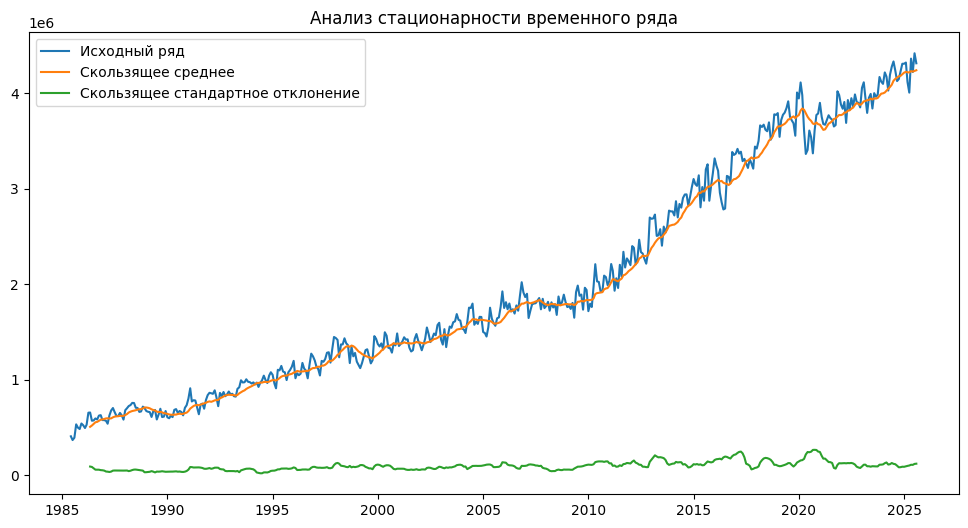

In [ ]:
# Проведение теста Дики-Фуллера

result = adfuller(timeseries)
print('Результаты теста Дики-Фуллера:')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Критические значения:')
for key, value in result[4].items():
  print(f'\t{key}: {value}')

# Визуализация скользящих статистик
rolling_mean = pd.Series(timeseries).rolling(window=12).mean()
rolling_std = pd.Series(timeseries).rolling(window=12).std()

plt.figure(figsize=(12,6))
plt.plot(timeseries, label='Исходный ряд')
plt.plot(rolling_mean, label='Скользящее среднее')
plt.plot(rolling_std, label='Скользящее стандартное отклонение')
plt.legend()
plt.title('Анализ стационарности временного ряда')
plt.show()

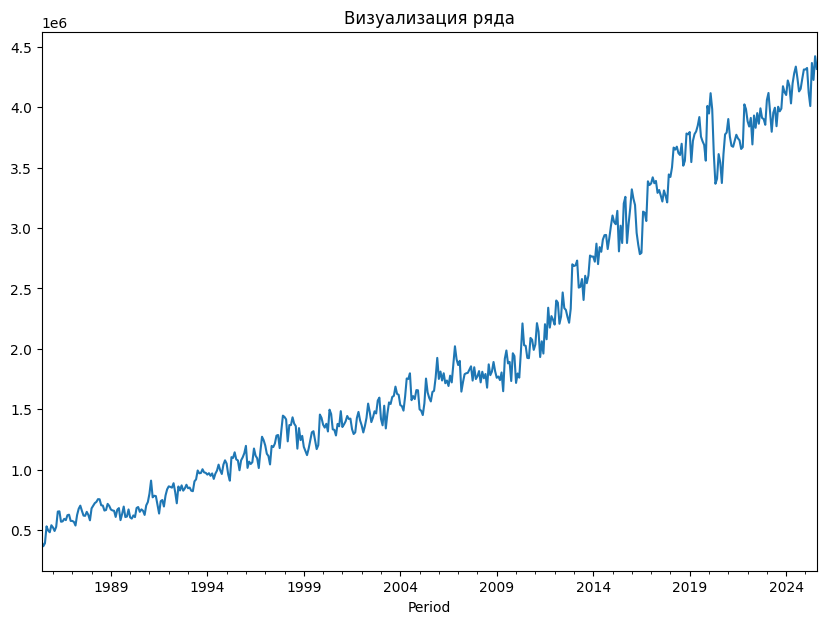

In [ ]:
# Визуализация ряда после предобработки
timeseries.plot(figsize=(10, 7), title='Визуализация ряда')
plt.show()

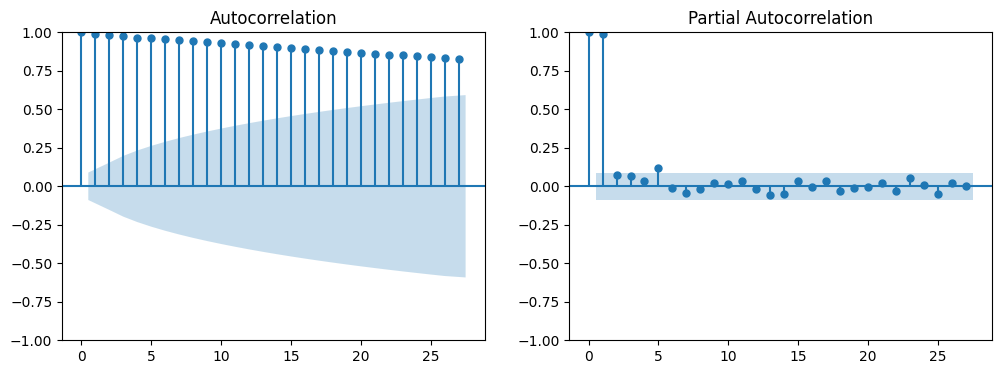

In [ ]:
# Визуальный анализ ACF и PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(timeseries, ax=axes[0])
plot_pacf(timeseries, ax=axes[1])
plt.show()

In [ ]:
# Подбор модели по AIC
p = range(0,10)
d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_aic = np.inf
for params in pdq:
  model_test = ARIMA(timeseries, order = params)
  result_test = model_test.fit()
  if result_test.aic < best_aic:
    best_pdq = params
    best_aic = result_test.aic
print(best_pdq, best_aic)

print(f"Лучшая модель: ARIMA{best_pdq} с AIC={best_aic:.2f}")

(9, 2, 1) 12467.30063447939
Лучшая модель: ARIMA(9, 2, 1) с AIC=12467.30


In [ ]:
# 3. Обучение оптимальной модели
model = ARIMA(timeseries, order=best_pdq)
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:         Volume (bbl/d)   No. Observations:                  483
Model:                 ARIMA(9, 2, 1)   Log Likelihood               -6222.650
Date:                Sun, 09 Nov 2025   AIC                          12467.301
Time:                        18:22:28   BIC                          12513.235
Sample:                    06-01-1985   HQIC                         12485.355
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3741      0.049     -7.655      0.000      -0.470      -0.278
ar.L2         -0.2934      0.052     -5.617      0.000      -0.396      -0.191
ar.L3         -0.3027      0.057     -5.347      0.0

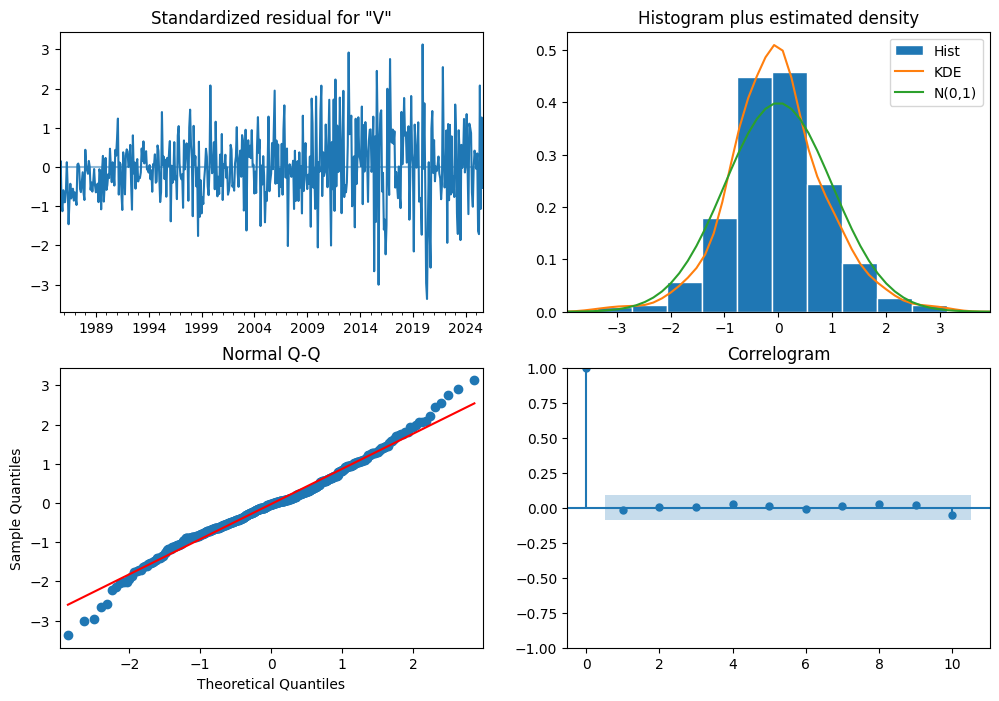

In [ ]:
# Проверка остатков модели
result.plot_diagnostics(figsize=(12, 8))
plt.show()

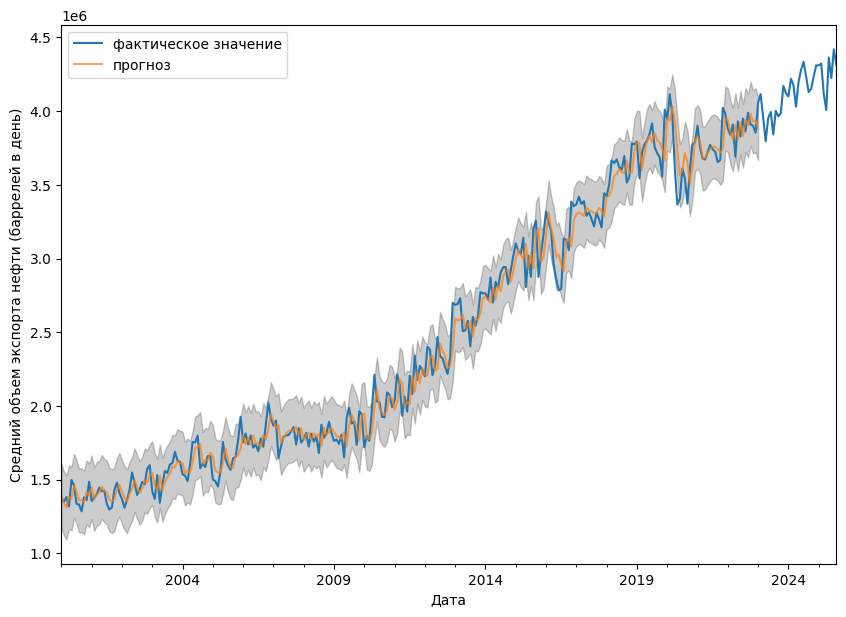

In [ ]:
# 4. Прогнозирование
pred = result.get_prediction(start='2000-01-01', end='2023-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = timeseries['2000':].plot(label='фактическое значение', figsize=(10, 7))
pred.predicted_mean.plot(ax=ax, label='прогноз', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Дата')
ax.set_ylabel('Средний объем экспорта нефти (баррелей в день)')
plt.legend()
plt.show()

In [ ]:
# 5.Оценка точности прогноза
forecasted = pred.predicted_mean[:'2021-03-01']
actual = timeseries['2000':]
mape = np.mean(np.abs((actual - forecasted)/actual))*100
mape

np.float64(3.7779995616042013)